In this Lab, we will explore the variance reduced methods (SAGA, SVRG and SARAH+). Note that SVRG and SARAH+ are very similar.

We will consider some **Least-square problem**

$$
F(w) = \frac1n \sum_{i=1}^n \frac12 (x_i ^T w - y_i)^2
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(804)

In [3]:
m=100
n=2

# xOpt - optimal solution
# A - matrix of data points
# L - Lipschitz constant

A = np.random.rand(m,n)
xOpt = np.random.randn(n)

# b is the vector of labels
b = np.matmul(A, xOpt) + 0.1*np.random.randn(m)

L = np.max(np.linalg.eig(np.matmul(A.T,A))[0])/m

xOpt = np.matmul(np.linalg.inv(np.matmul(A.T,A)), np.matmul(A.T, b))
L = np.max(np.linalg.eig(np.matmul(A.T,A))[0])/m
fOpt = 0.5/m * np.linalg.norm(np.matmul(A, xOpt)-b)**2


x_vals = np.arange(0, 0.6, .05)
y_vals = np.arange(-0.7, -0.1, 0.05)
X, Y = np.meshgrid(x_vals, y_vals)

Z = (X + Y) * 0

for i in range(m):
  Z+=1/m*0.5*(  A[i,0]*X + A[i,1]*Y - b[i]  )**2

## SGD algorithm

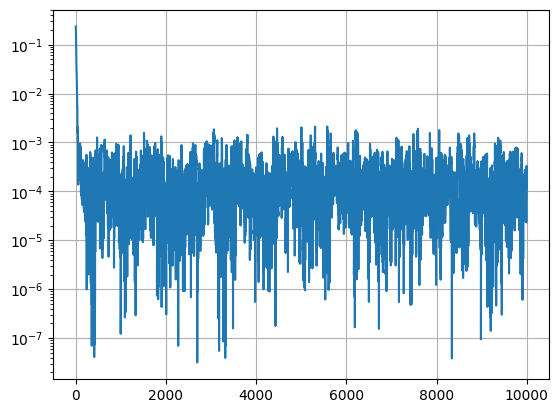

In [4]:
gamma = 0.1
x = xOpt*0

error = []
for it in range(10000):
  gm = x*0

  i = np.random.randint(m)
  # that's the gradient
  g =  (np.dot(A[i,:],x)-b[i])*A[i,:]
  # update
  x = x - gamma  * g

  # error
  f = 0.5/m * np.linalg.norm(np.matmul(A, x)-b)**2

  error.append(f-fOpt)
plt.semilogy(error)
plt.grid()

# Task 1: Implement SAGA Method

*  Use the idea with the big table to implement SAGA method. 
*  For the first epoch, run just SGD method to fill the all table with the gradients
*  Plot the evolution of $F(w_k) - F^*$

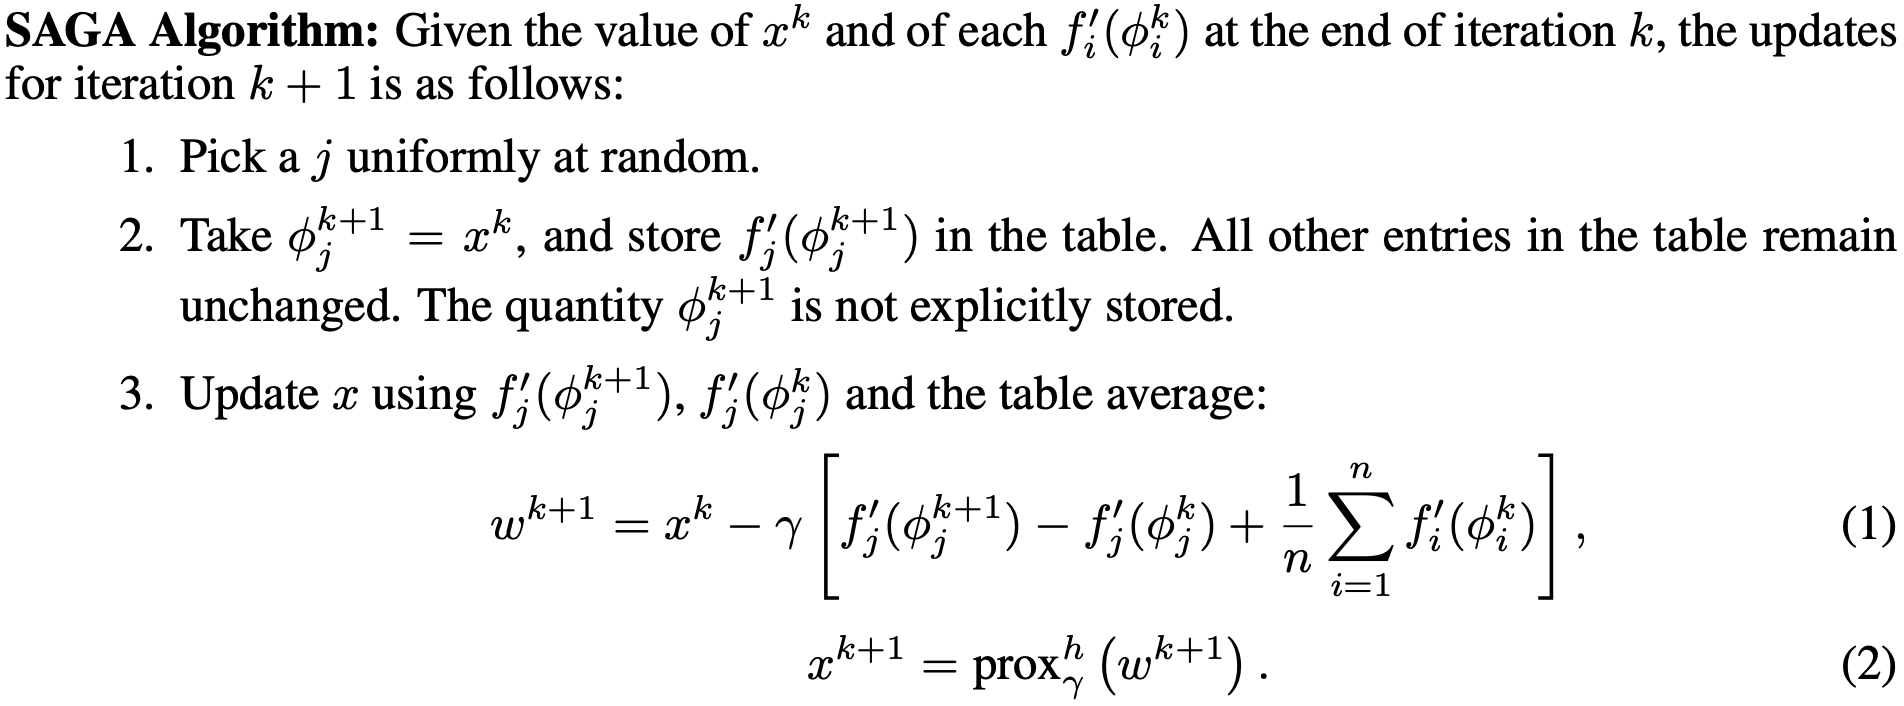

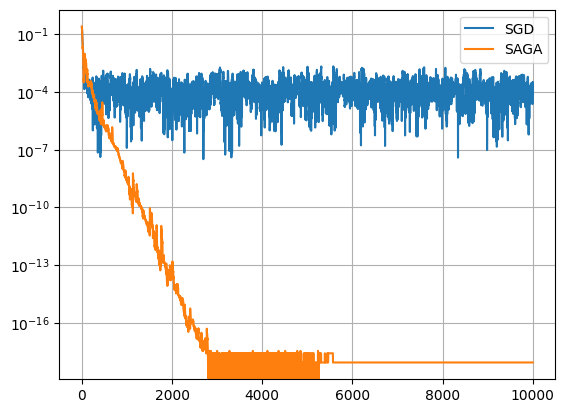

In [5]:
## Implement SAGA algorithm

table = (np.dot(A, x) - b) * A.T ## fill the table with the gradients, first epoch
x = xOpt*0
gamma = 0.09
error_saga = []

for k in range(10000):
    j = np.random.randint(m)

    g =  (np.dot(A[j,:], x) - b[j]) * A[j,:]
    x = x - gamma * (g - table[:,j] + np.mean(table, axis=1))
    table[:,j] = g

    # error
    f = 0.5/m * np.linalg.norm(np.matmul(A, x)-b)**2

    error_saga.append(f-fOpt)

plt.semilogy(error, label='SGD')
plt.semilogy(error_saga, label='SAGA')
plt.legend()
plt.grid()
plt.show()

# Task 2: Decrease a memory of the table and avoid computing the average of the table

*  Note that each iteration, only one column of the table is changed. Refactor your code from previous task to avoid computing the average of the table, by having a vector that will represent the average of the table and just each iteration update this vector
*  Now, think how to decrease the size of the table from $n \times d$ to just $n$. Hint, write how the gradient is computed and think how to make it more efficient (this is applicable for generalized linear models).
*  Show again the evolution of $F(w_k) - F^*$


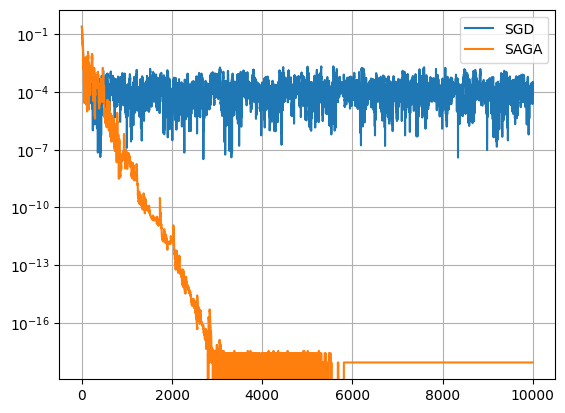

In [6]:
x = xOpt*0
gamma = 0.09

table = (np.dot(A, x) - b) * A.T ## fill the table with the gradients, first epoch
error_saga = []
ave_table = np.mean(table, axis=1)

for k in range(10000):
    j = np.random.randint(m)

    g =  (np.dot(A[j,:], x) - b[j]) * A[j,:]

    x = x - gamma * (g - table[:,j] + ave_table)

    ## update the average
    ## diff between old and new gradient / m + old average
    ave_table += (g - table[:, j]) / m

    table[:,j] = g

    # error
    f = 0.5/m * np.linalg.norm(np.matmul(A, x)-b)**2

    error_saga.append(f-fOpt)

plt.semilogy(error, label='SGD')
plt.semilogy(error_saga, label='SAGA')
plt.legend()
plt.grid()
plt.show()


In [7]:
#Now, think how to decrease the size of the table from $n \times d$ to just $n$. Hint, write how the gradient is
#computed and think how to make it more efficient (this is applicable for generalized linear models).

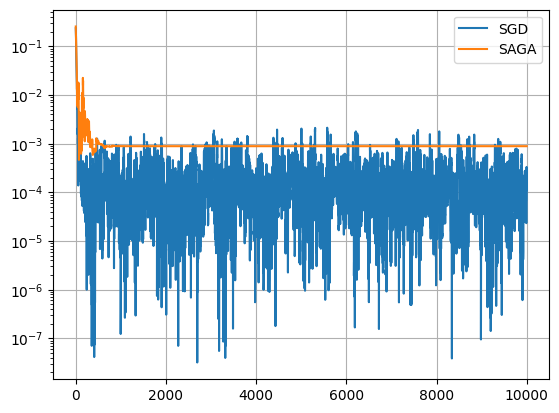

In [8]:
x = xOpt*0
gamma = 0.09

table = np.dot(A, x) - b
error_saga = []
ave_table = np.mean(table)

for k in range(10000):
    j = np.random.randint(m)

    component = np.dot(A[j,:], x) - b[j]

    g = component * A[j,:]

    old_scalar = table[j]

    x = x - gamma * (g - old_scalar * A[j, :] + ave_table * A[j,:])

    ## update the average
    ## diff between old and new gradient / m + old average
    ave_table += (component - old_scalar) / m

    table[j] = component

    # error
    f = 0.5/m * np.linalg.norm(np.matmul(A, x)-b)**2

    error_saga.append(f-fOpt)

plt.semilogy(error, label='SGD')
plt.semilogy(error_saga, label='SAGA')
plt.legend()
plt.grid()
plt.show()

# Task 3: Implement SVRG
*  Now, implement SVRG 
*  Compare it with SAGA by showing the evolution of $F(w_k) - F^*$
*  Note: play with different values of $m$ to make SVRG slow and faster.

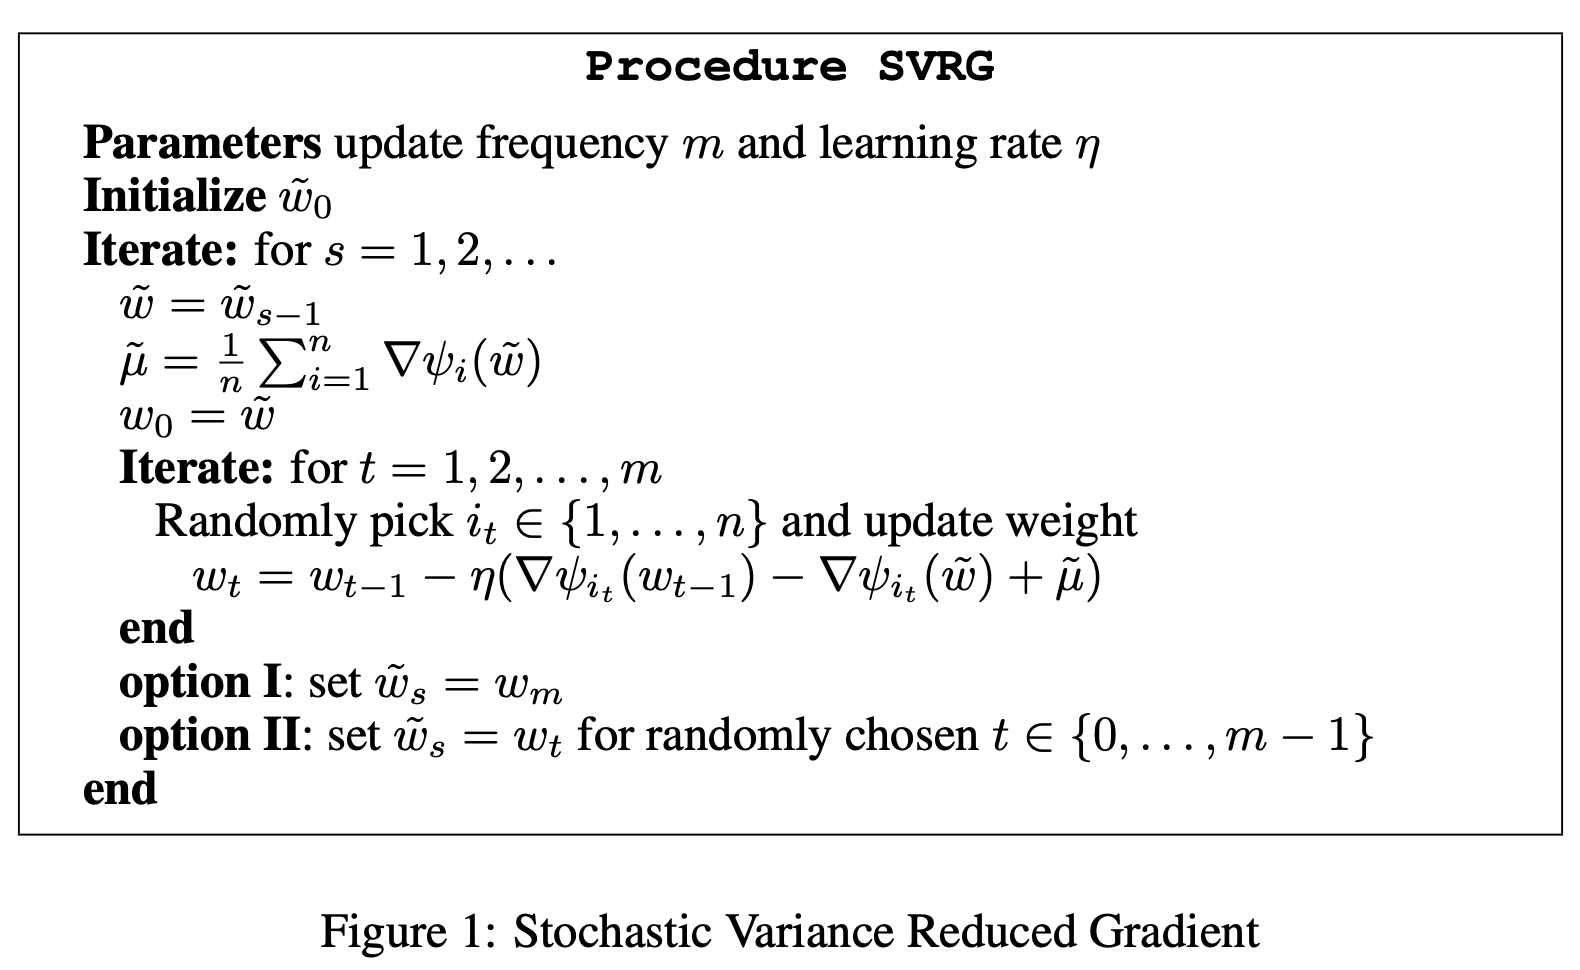




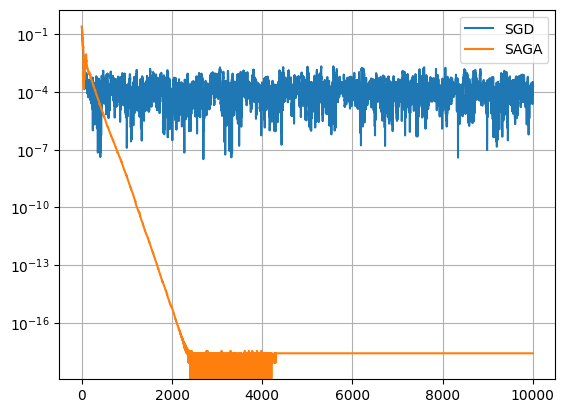

In [9]:
x = xOpt*0
gamma = 0.09

t = 100
s = 100
error_svrg = []

for _ in range(s):
    mu = np.mean((np.dot(A, x) - b) * A.T, axis=1)
    h_x = x

    for _ in range(t):
        j = np.random.randint(m)

        h_g =  (np.dot(A[j,:], h_x) - b[j]) * A[j,:]
        g = (np.dot(A[j,:], x) - b[j]) * A[j,:]

        h_x = h_x - gamma * (h_g - g + mu)

        f = 0.5/m * np.linalg.norm(np.matmul(A, h_x)-b)**2
        error_svrg.append(f-fOpt)
    #update
    x = h_x


plt.semilogy(error, label='SGD')
plt.semilogy(error_svrg, label='SAGA')
plt.legend()
plt.grid()
plt.show()

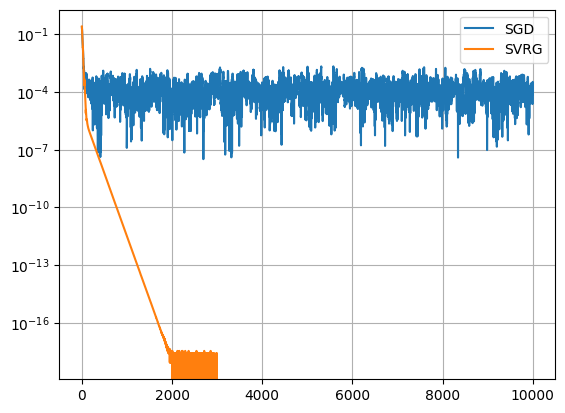

In [10]:
x = xOpt*0
gamma = 0.09

t = 30
s = 100
error_svrg = []

for _ in range(s):
    mu = np.mean((np.dot(A, x) - b) * A.T, axis=1)
    h_x = x

    for _ in range(t):
        j = np.random.randint(m)

        h_g =  (np.dot(A[j,:], h_x) - b[j]) * A[j,:]
        g = (np.dot(A[j,:], x) - b[j]) * A[j,:]

        h_x = h_x - gamma * (h_g - g + mu)

        f = 0.5/m * np.linalg.norm(np.matmul(A, h_x)-b)**2
        error_svrg.append(f-fOpt)
    #update
    x = h_x


plt.semilogy(error, label='SGD')
plt.semilogy(error_svrg, label='SVRG')
plt.legend()
plt.grid()
plt.show()

# Task 4: SARAH+

*  You should have observed that tuning $m$ is quite tricky for SVRG
*  Read about SARAH+ and compare it with the previous algorithms. Note: use $\gamma = 0.1$ (early stopping parameter for SARAH+)

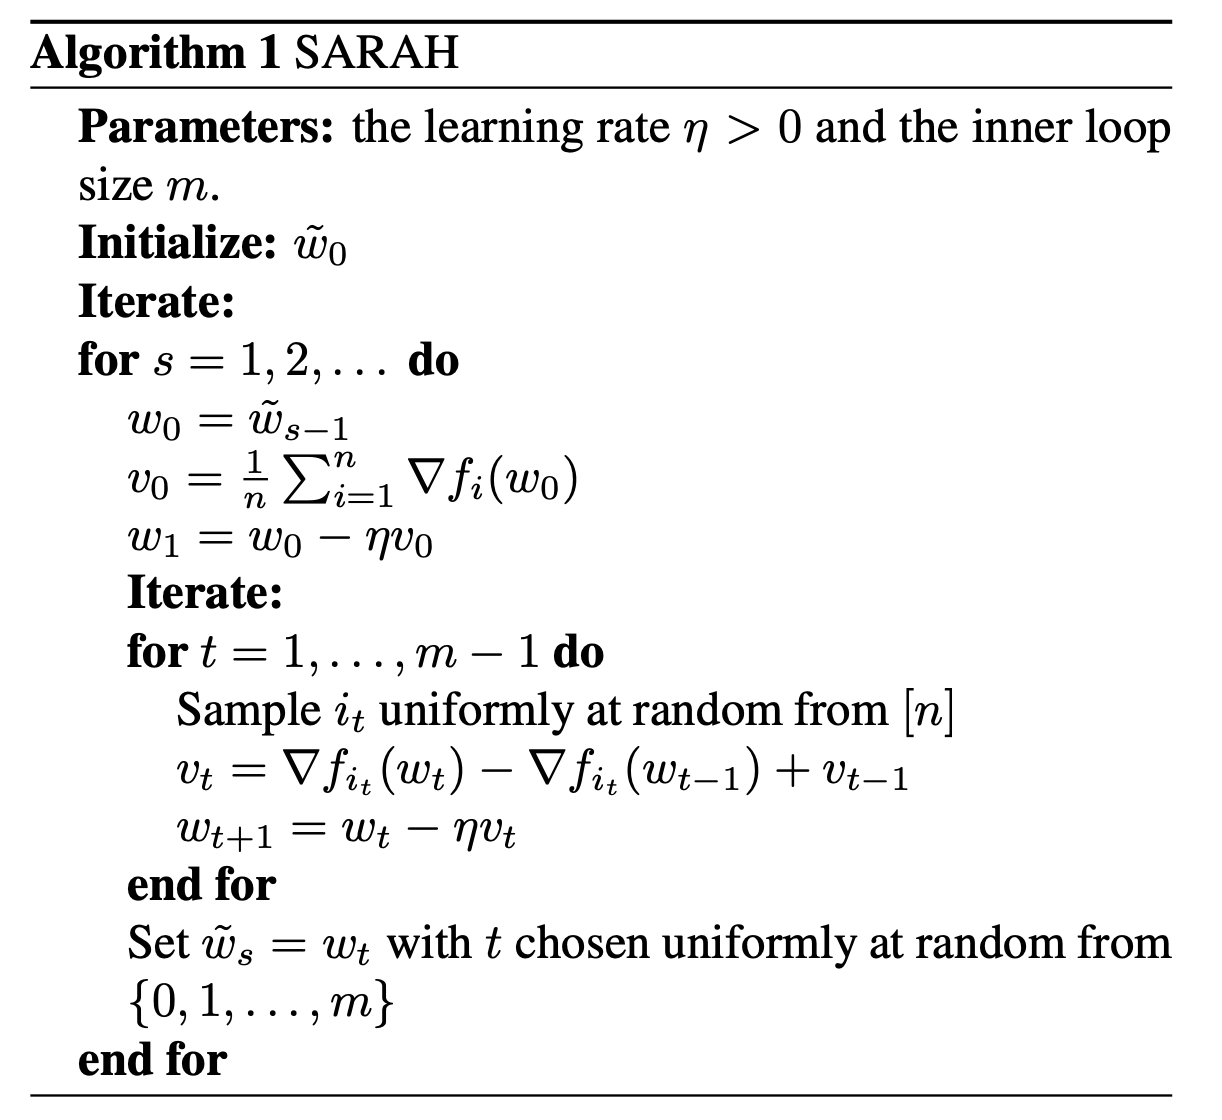

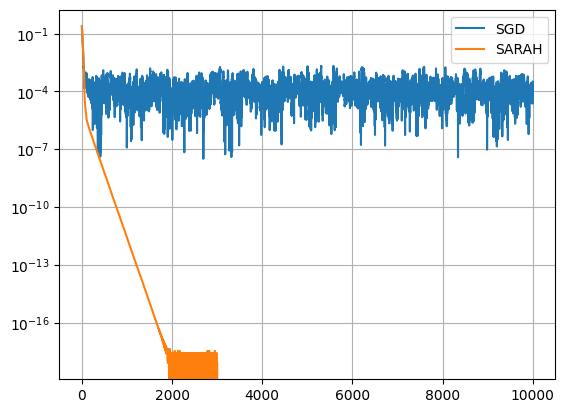

In [11]:
x = xOpt*0
gamma = 0.09

t = 30
s = 100
error_svrg = []

for _ in range(s):
    mu = np.mean((np.dot(A, x) - b) * A.T, axis=1)
    h_x = x - gamma * mu

    for _ in range(t):
        j = np.random.randint(m)

        h_g =  (np.dot(A[j,:], h_x) - b[j]) * A[j,:]
        g = (np.dot(A[j,:], x) - b[j]) * A[j,:]

        mu = h_g - g + mu

        ##updata
        x = h_x
        h_x = h_x - gamma * mu

        f = 0.5/m * np.linalg.norm(np.matmul(A, h_x)-b)**2
        error_svrg.append(f-fOpt)
    #update
    x = h_x


plt.semilogy(error, label='SGD')
plt.semilogy(error_svrg, label='SARAH')
plt.legend()
plt.grid()
plt.show()

SARAH+

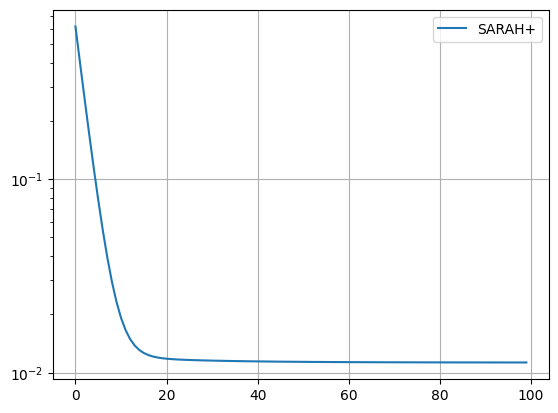

In [17]:
# Parameters
eta = 0.01 # learning rate
gamma = 0.1 # must satisfy 0 < gamma <= 1
S = 100 # maximum inner loop size
m = 30 # outer loop size
x = xOpt * 0 # initialization of x
error_sarah_plus = []

# SARAH+ Algorithm
w = x.copy()
for s in range(1, S + 1):
    v = np.mean((np.dot(A, w) - b) * A.T, axis=1)
    w_prev = w.copy()
    w = w - eta * v
    t = 1

    while np.linalg.norm(v)**2 > gamma * np.linalg.norm(v)**2 and t <= m:
        i_t = np.random.randint(n) # Sample i_t uniformly at random from [n]
        v_tilde = (np.dot(A[i_t], w) - b[i_t]) * A[i_t] - (np.dot(A[i_t], w_prev) - b[i_t]) * A[i_t] + v
        w_prev = w.copy()
        w = w - eta * v_tilde
        t += 1

    error_sarah_plus.append(0.5 / m * np.linalg.norm(np.dot(A, w) - b)**2 - fOpt)

# Plotting the error
plt.semilogy(error_sarah_plus, label='SARAH+')
# plt.semilogy(error_svrg, label='SARAH')
plt.legend()
plt.grid()
plt.show()